# SEEG Electrode Accuracy: Summary of Findings

## 1. Dataset Overview
- **Total electrodes:** 2,658 (reduced to 2,459 after outlier removal)
- Each electrode has planned vs actual coordinates at **entry** and **tip**, from which multiple accuracy metrics were derived.

---

## 2. Accuracy Metrics
- **Tip Euclidean Error:** Mean = 1.94 ± 0.86 mm  
- **Entry Euclidean Error:** Mean = 1.43 ± 0.73 mm  
- **Angular Deviations:**  
  - Line angle: Mean = 1.16 rad (~66°)  
  - Radial angle: Mean = 1.73 rad (~99°)  

> 🔎 Tip errors are slightly larger than entry errors, suggesting accumulated angular drift.

---

## 3. Group-wise Comparisons
- **Statistically significant differences** in angular error across:
  - **Electrode targets** (`electrode`)  
  - **Planning systems** (`group`)  
  - **Hemispheres** (`side`) — limited to entry error

> Electrode target and surgical group were stronger determinants of accuracy than hemisphere.

---

## 4. Principal Component Analysis (PCA)
- PCA revealed that ~88% of variability in accuracy could be explained by three components.
- **PC1**: general magnitude of error  
- **PC2**: contrast between angular and positional error  
- Modest separation between groups and electrodes, but not diagnostic.

---

## 5. Geometric Feature Engineering
- **Trajectory Length** and **Entry Angle** were derived from planned coordinates:
  - Length: 15–122 mm (Mean = 51.6 mm)
  - Angle: 67°–179° (Mean = 111° from vertical)

### Correlation Findings:
- **Tip error increases with trajectory length** (r ≈ 0.54)
- **Angular error increases with entry angle** (r ≈ 0.33)

---

## 6. Regression Modeling

### 🔹 Model 1: Tip Error ~ Trajectory Length + Entry Angle
- **Trajectory length significant** (p < 0.001), small effect size (+0.0071 mm per mm)
- **Entry angle not significant** (p = 0.42)
- **R² = 0.025** — limited explanatory power

### 🔹 Model 2: + Group (System)
- Adding `group` raised **R² to 0.173**
- Many group effects were non-significant individually, but **contributed collectively**
- Confirms that **planning system and trajectory geometry meaningfully influence accuracy**

---

## 🧠 Takeaways
- **Trajectory depth** is a robust predictor of targeting error.
- **Planning systems differ in performance**, even after accounting for depth/angle.
- **Oblique insertions (steeper angles)** show higher angular error.
- PCA is a useful summarization tool but lacks clear clinical interpretability.


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

In [9]:
# Load the uploaded CSV file
file_path = "/Users/alaataha/Documents/GitHub/seeg_accuracy_2025/output/2025_SEEG_robot_accuracy.csv"
df = pd.read_csv(file_path)

# Display basic information and the first few rows to understand the structure
df_info = df.info()
df_head = df.head()

df_info, df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subject             2658 non-null   object 
 1   electrode           2658 non-null   object 
 2   group               2658 non-null   object 
 3   side                2658 non-null   object 
 4   plannedTipX         2658 non-null   float64
 5   plannedTipY         2658 non-null   float64
 6   plannedTipZ         2658 non-null   float64
 7   plannedEntryX       2658 non-null   float64
 8   plannedEntryY       2658 non-null   float64
 9   plannedEntryZ       2658 non-null   float64
 10  actualTipX          2658 non-null   float64
 11  actualTipY          2658 non-null   float64
 12  actualTipZ          2658 non-null   float64
 13  actualEntryX        2658 non-null   float64
 14  actualEntryY        2658 non-null   float64
 15  actualEntryZ        2658 non-null   float64
 16  euclid

(None,
     subject electrode  group side  plannedTipX  plannedTipY  plannedTipZ  \
 0  sub-D098      LPHc    PHc    L      -31.602         13.2        3.279   
 1  sub-D098     LPOFr   POFr    L        2.300         69.2       -5.500   
 2  sub-D098     LAOFr   AOFr    L        2.000         83.6        1.500   
 3  sub-D098      LAIn    AIn    L      -34.600         58.8        4.600   
 4  sub-D098    LMesFr  MesFr    L        1.000         75.5       -5.600   
 
    plannedEntryX  plannedEntryY  plannedEntryZ  ...  actualTipZ  actualEntryX  \
 0        -76.724          27.80         13.348  ...      -1.383      -75.8759   
 1        -50.998          81.10         25.598  ...      -6.428      -49.7994   
 2        -49.228          84.50         18.452  ...       1.569      -48.1345   
 3        -13.046          60.11         77.200  ...       3.296      -13.0002   
 4        -13.491          76.80         66.693  ...      -5.881      -13.9613   
 
    actualEntryY  actualEntryZ  euc

(199, np.float64(4.603381019931831), np.float64(3.5822426825188654))

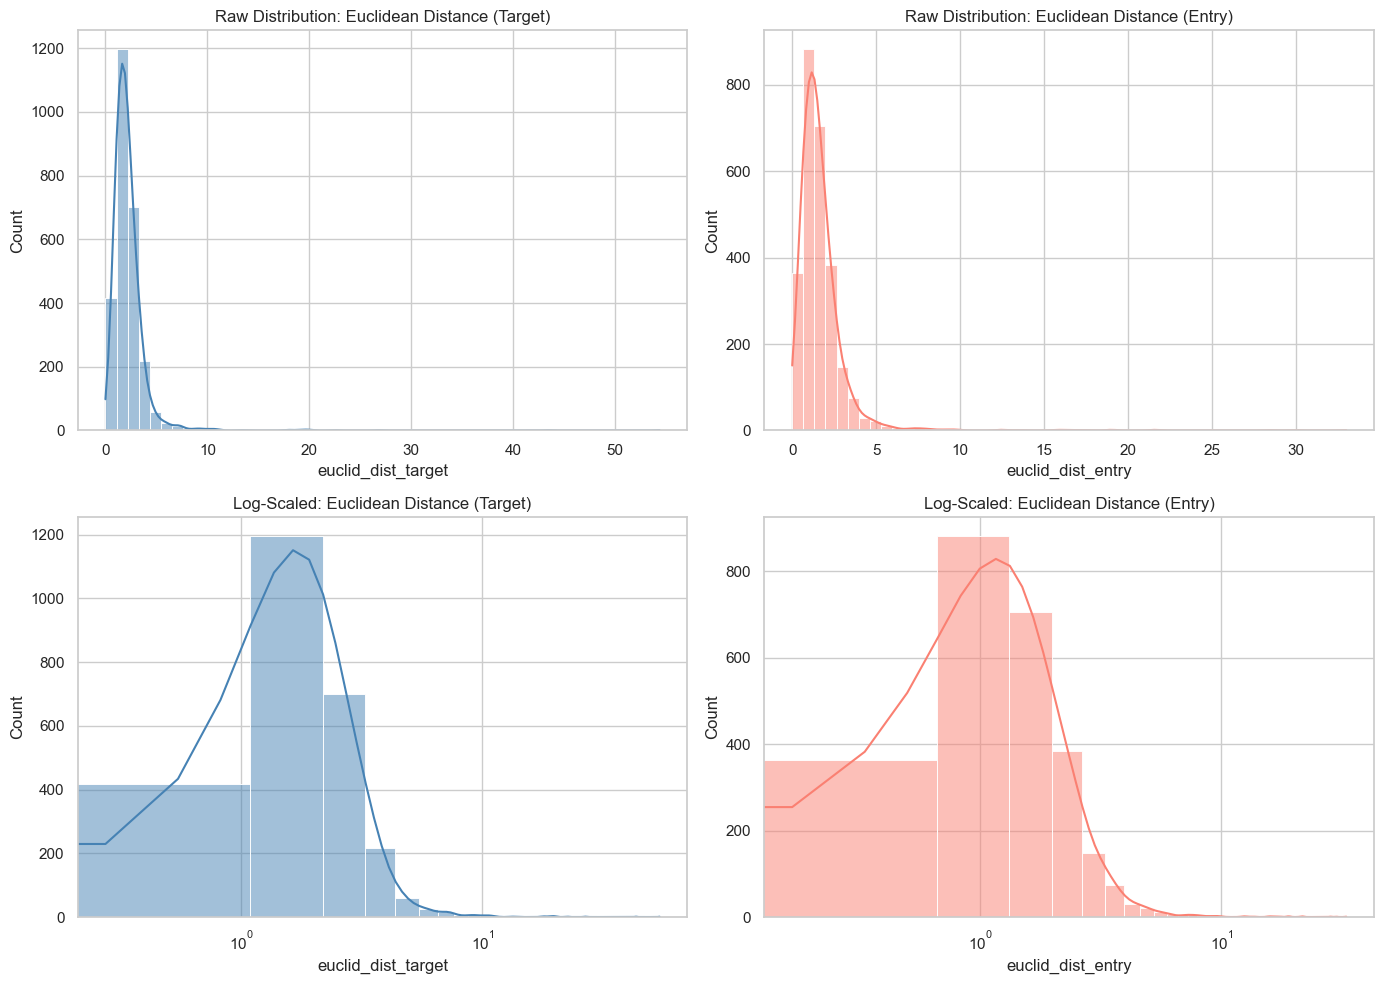

In [10]:
# Step 1: Visualize current error distributions including outliers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Raw distributions
sns.histplot(df['euclid_dist_target'], bins=50, kde=True, ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title("Raw Distribution: Euclidean Distance (Target)")

sns.histplot(df['euclid_dist_entry'], bins=50, kde=True, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title("Raw Distribution: Euclidean Distance (Entry)")

# Log-scaled plots
sns.histplot(df['euclid_dist_target'], bins=50, kde=True, ax=axes[1, 0], color='steelblue')
axes[1, 0].set_xscale("log")
axes[1, 0].set_title("Log-Scaled: Euclidean Distance (Target)")

sns.histplot(df['euclid_dist_entry'], bins=50, kde=True, ax=axes[1, 1], color='salmon')
axes[1, 1].set_xscale("log")
axes[1, 1].set_title("Log-Scaled: Euclidean Distance (Entry)")

fig.tight_layout()

# Step 2: Define outlier thresholds using IQR method
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    return data[data[column] <= upper_bound], upper_bound

df_clean_target, ub_target = remove_outliers_iqr(df, 'euclid_dist_target')
df_clean_both, ub_entry = remove_outliers_iqr(df_clean_target, 'euclid_dist_entry')

# Count removed rows
removed_count = len(df) - len(df_clean_both)

removed_count, ub_target, ub_entry


In [11]:
# Use the cleaned dataset (after removing outliers)
df_clean = df_clean_both.copy()

# Summary of available accuracy metrics in the cleaned dataset
accuracy_metrics = df_clean[[
    'euclid_dist_target',
    'euclid_dist_entry',
    'radial_dist_target',
    'radial_dist_entry',
    'radial_angle',
    'line_angle'
]]

# Show summary statistics
summary_stats = accuracy_metrics.describe().T
summary_stats["IQR"] = summary_stats["75%"] - summary_stats["25%"]
summary_stats["range"] = summary_stats["max"] - summary_stats["min"]
summary_stats["missing"] = df_clean.isna().sum()[accuracy_metrics.columns]

summary_stats


,count,mean,std,min,25%,50%,75%,max,IQR,range,missing
euclid_dist_target,2459.0,1.937466,0.855767,0.00000,1.299858,1.839705,2.461917,4.593414,1.162059,4.593414,0
euclid_dist_entry,2459.0,1.426081,0.731345,0.00000,0.881280,1.318756,1.879625,3.580724,0.998345,3.580724,0
radial_dist_target,2459.0,1.452527,0.821939,0.00000,0.844418,1.314126,1.924320,4.463035,1.079902,4.463035,0
radial_dist_entry,2459.0,1.085736,0.600285,0.00000,0.620692,1.019919,1.438931,3.309571,0.818240,3.309571,0
radial_angle,2458.0,1.733237,1.043269,0.01771,0.970904,1.546247,2.270139,8.007738,1.299235,7.990028,1
line_angle,2458.0,1.155227,0.783074,0.01382,0.614853,0.990035,1.491910,5.574602,0.877057,5.560782,1


/var/folders/1_/pqzl0fjs2595xmp99j42cvmc0000gn/T/ipykernel_18344/669056217.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='side', y='euclid_dist_entry', palette='pastel')
/var/folders/1_/pqzl0fjs2595xmp99j42cvmc0000gn/T/ipykernel_18344/669056217.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean[df_clean['group'].isin(top_groups)], x='group', y='radial_angle', palette='muted')
/var/folders/1_/pqzl0fjs2595xmp99j42cvmc0000gn/T/ipykernel_18344/669056217.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(d

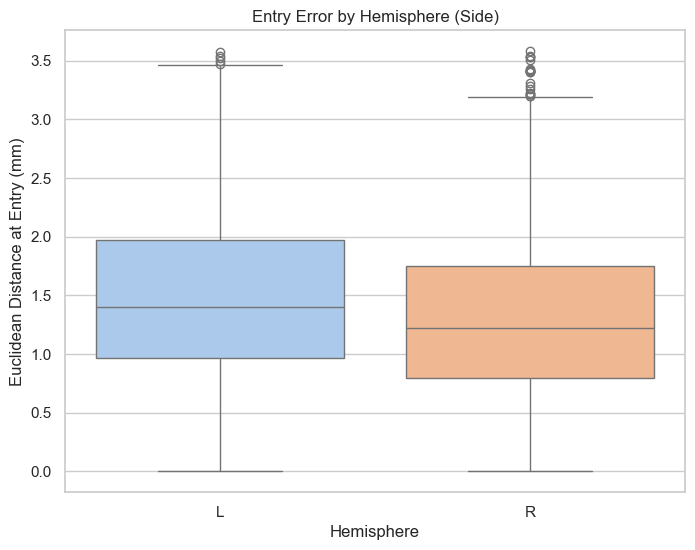

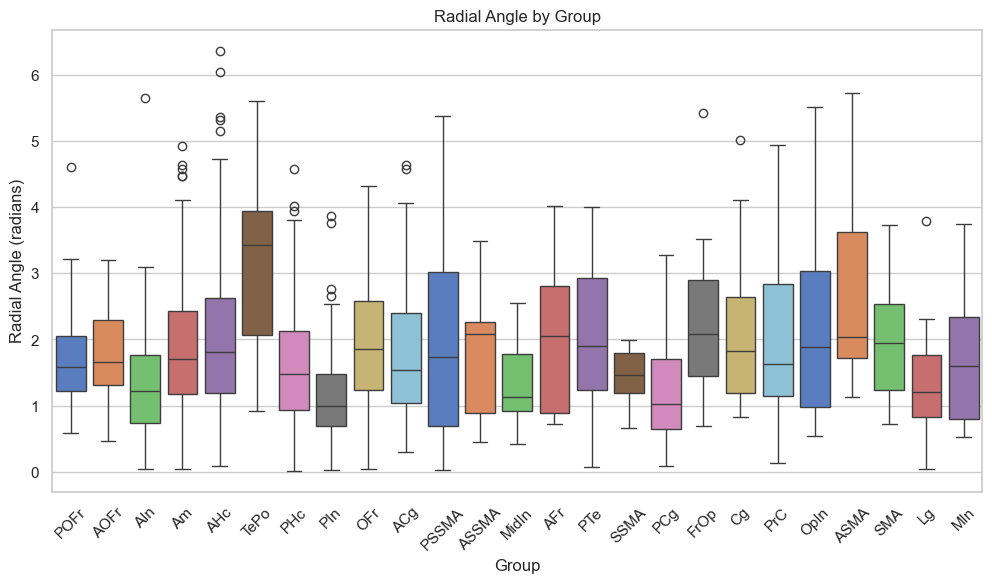

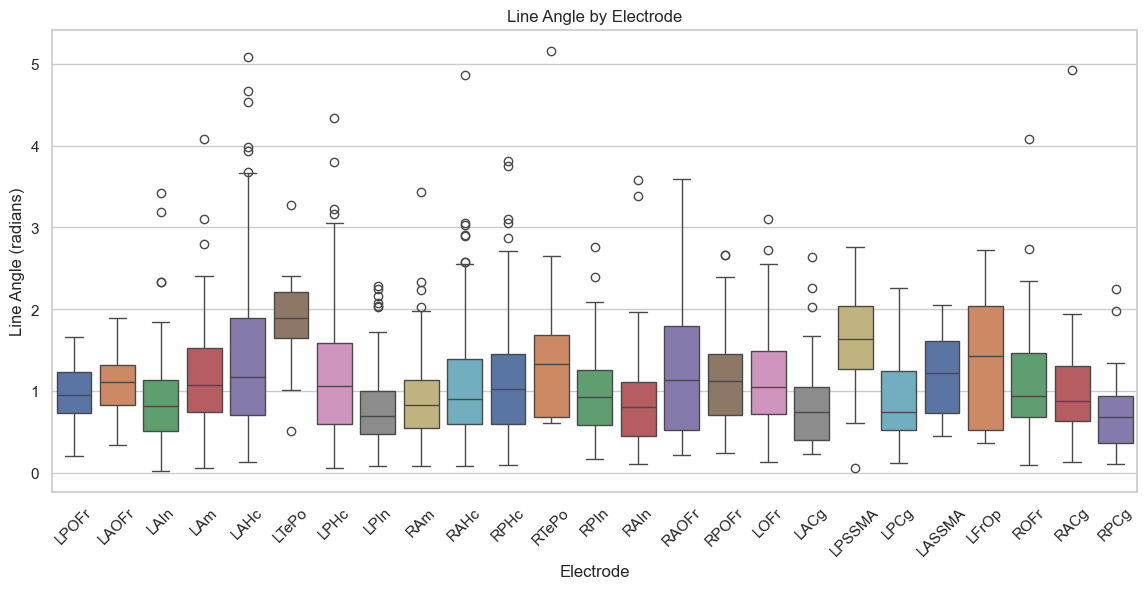

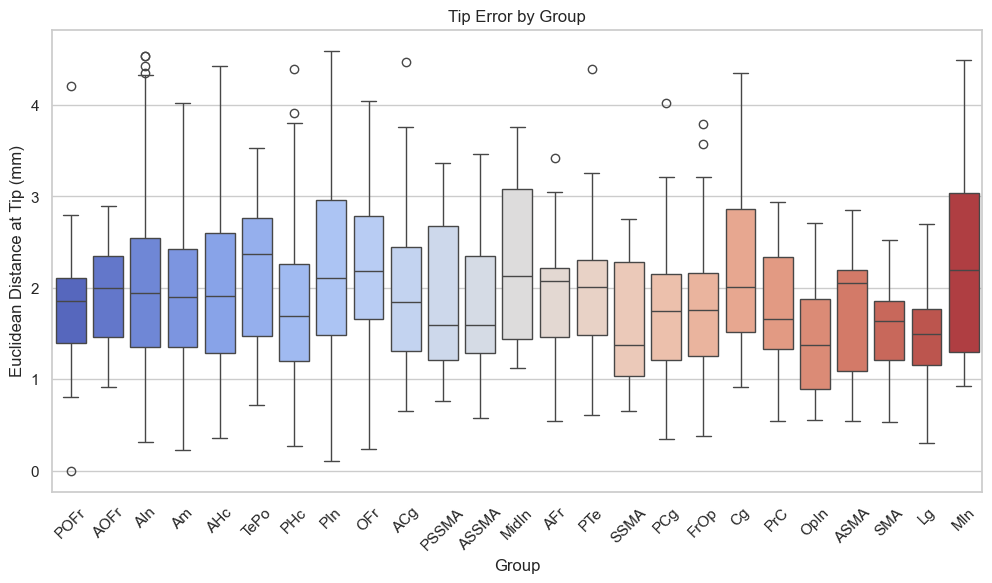

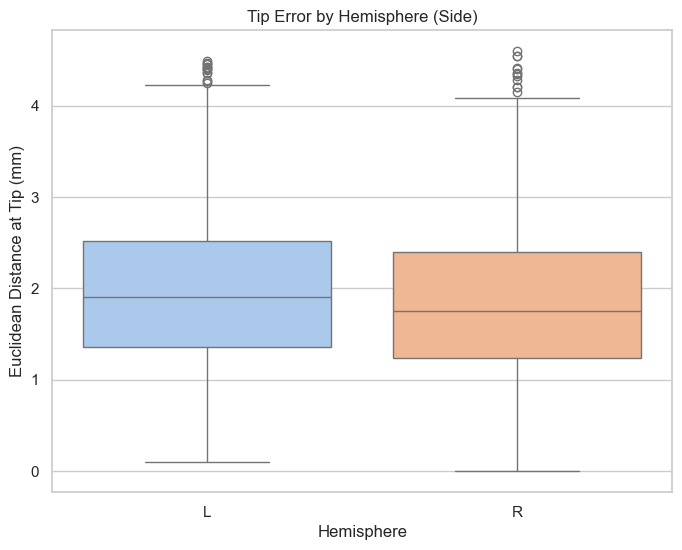

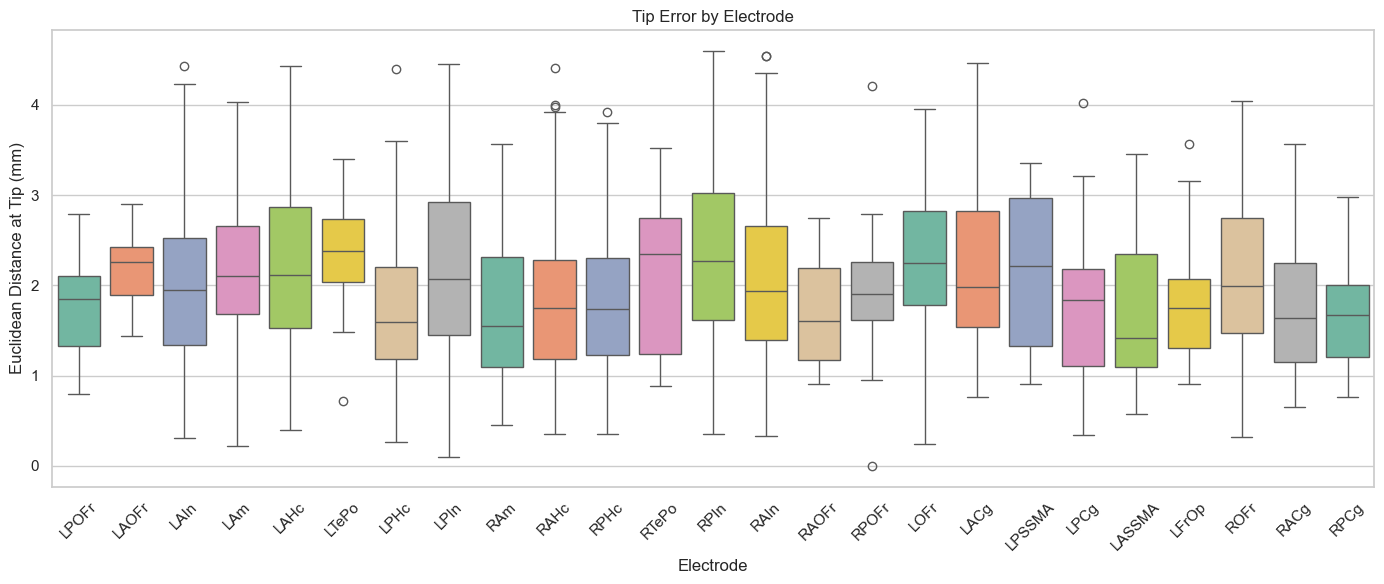

<Figure size 1000x600 with 0 Axes>

In [18]:
# 1. Entry error by hemisphere (side)
fig1, ax1 = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_clean, x='side', y='euclid_dist_entry', palette='pastel')
ax1.set_title("Entry Error by Hemisphere (Side)")
ax1.set_ylabel("Euclidean Distance at Entry (mm)")
ax1.set_xlabel("Hemisphere")

# 2. Radial angle by group
fig2, ax2 = plt.subplots(figsize=(12, 6))
top_groups = df_clean['group'].value_counts().nlargest(25).index
sns.boxplot(data=df_clean[df_clean['group'].isin(top_groups)], x='group', y='radial_angle', palette='muted')
ax2.set_title("Radial Angle by Group")
ax2.set_ylabel("Radial Angle (radians)")
ax2.set_xlabel("Group")
ax2.tick_params(axis='x', rotation=45)

# 3. Line angle by electrode (limited to top 10 most common electrodes for readability)
fig3, ax3 = plt.subplots(figsize=(14, 6))
top_electrodes = df_clean['electrode'].value_counts().nlargest(25).index
sns.boxplot(data=df_clean[df_clean['electrode'].isin(top_electrodes)], x='electrode', y='line_angle', palette='deep')
ax3.set_title("Line Angle by Electrode")
ax3.set_ylabel("Line Angle (radians)")
ax3.set_xlabel("Electrode")
ax3.tick_params(axis='x', rotation=45)

# 4. Euclidean distance at tip by group (top 10 groups)
fig4, ax4 = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df_clean[df_clean['group'].isin(top_groups)], x='group', y='euclid_dist_target', palette='coolwarm')
ax4.set_title("Tip Error by Group")
ax4.set_ylabel("Euclidean Distance at Tip (mm)")
ax4.set_xlabel("Group")
ax4.tick_params(axis='x', rotation=45)

# 5. Tip error by hemisphere
fig5, ax5 = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_clean, x='side', y='euclid_dist_target', palette='pastel')
ax5.set_title("Tip Error by Hemisphere (Side)")
ax5.set_ylabel("Euclidean Distance at Tip (mm)")
ax5.set_xlabel("Hemisphere")

# 6. Tip error by electrode (top 10 electrodes)
fig6, ax6 = plt.subplots(figsize=(14, 6))
sns.boxplot(data=df_clean[df_clean['electrode'].isin(top_electrodes)], x='electrode', y='euclid_dist_target', palette='Set2')
ax6.set_title("Tip Error by Electrode")
ax6.set_ylabel("Euclidean Distance at Tip (mm)")
ax6.set_xlabel("Electrode")
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()

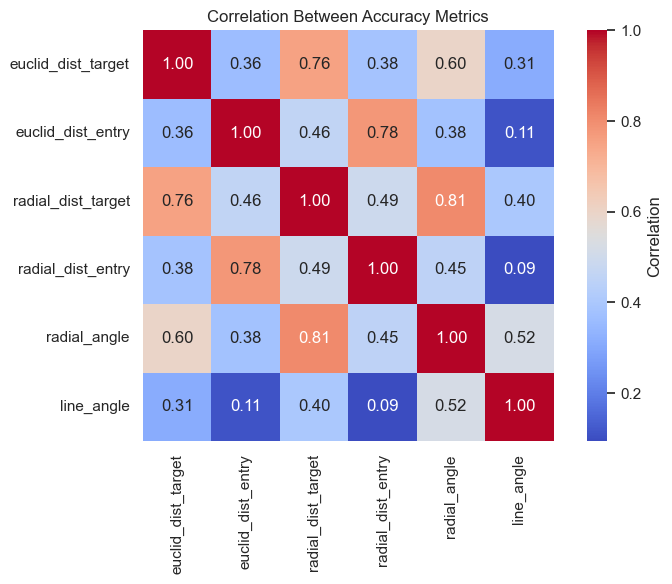

In [19]:
# Select relevant numeric variables for correlation analysis
corr_vars = [
    'euclid_dist_target',
    'euclid_dist_entry',
    'radial_dist_target',
    'radial_dist_entry',
    'radial_angle',
    'line_angle'
]

# Compute correlation matrix
corr_matrix = df_clean[corr_vars].corr()

# Generate heatmap of correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'label': 'Correlation'})
plt.title("Correlation Between Accuracy Metrics")
plt.tight_layout()
plt.show()


In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Drop rows with any missing values in the accuracy metrics
df_pca = df_clean[corr_vars].dropna()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca)

# Run PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with explained variance
explained_variance = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
    "Explained Variance Ratio": pca.explained_variance_ratio_,
    "Cumulative Variance": pca.explained_variance_ratio_.cumsum()
})

# Also create a loading matrix to interpret components
loadings = pd.DataFrame(pca.components_.T, 
                        index=corr_vars, 
                        columns=[f"PC{i+1}" for i in range(len(corr_vars))])

explained_variance.head()


,PC,Explained Variance Ratio,Cumulative Variance
0,PC1,0.564074,0.564074
1,PC2,0.206266,0.770341
2,PC3,0.111066,0.881407
3,PC4,0.059309,0.940715
4,PC5,0.035656,0.976371


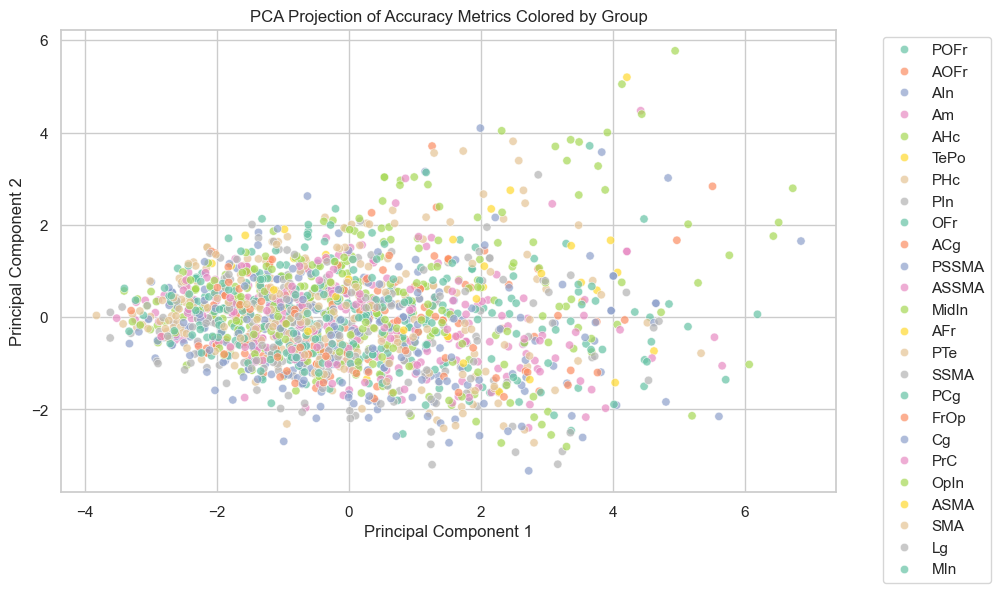

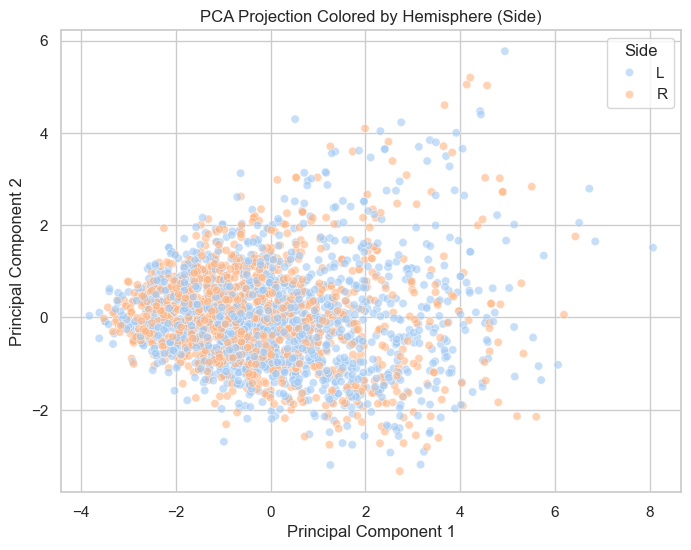

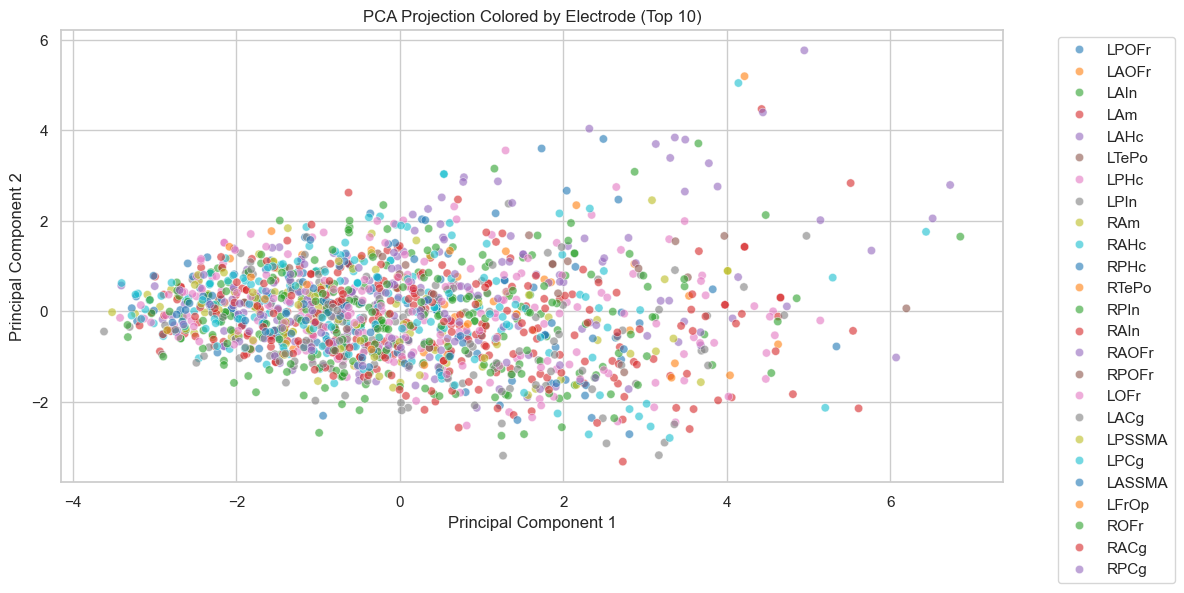

In [24]:
# Add PC1 and PC2 projections to the cleaned dataframe (excluding rows with missing error metrics)
df_clean_pca = df_clean.loc[df_pca.index].copy()
df_clean_pca["PC1"] = X_pca[:, 0]
df_clean_pca["PC2"] = X_pca[:, 1]

# 1. PCA projection colored by group (top 10 only)
fig1, ax1 = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df_clean_pca[df_clean_pca['group'].isin(top_groups)], 
                x="PC1", y="PC2", hue="group", alpha=0.7, palette="Set2")
ax1.set_title("PCA Projection of Accuracy Metrics Colored by Group")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. PCA projection colored by side
fig2, ax2 = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df_clean_pca, x="PC1", y="PC2", hue="side", alpha=0.6, palette="pastel")
ax2.set_title("PCA Projection Colored by Hemisphere (Side)")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 2")
ax2.legend(title="Side")

# 3. PCA projection colored by electrode (top 10 only)
fig3, ax3 = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=df_clean_pca[df_clean_pca['electrode'].isin(top_electrodes)], 
                x="PC1", y="PC2", hue="electrode", alpha=0.6, palette="tab10")
ax3.set_title("PCA Projection Colored by Electrode (Top 10)")
ax3.set_xlabel("Principal Component 1")
ax3.set_ylabel("Principal Component 2")
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [25]:
# Compute trajectory vector from planned entry to tip
entry_coords = df_clean[['plannedEntryX', 'plannedEntryY', 'plannedEntryZ']].values
tip_coords = df_clean[['plannedTipX', 'plannedTipY', 'plannedTipZ']].values

# Derive trajectory length (Euclidean norm of planned vector)
trajectory_vector = tip_coords - entry_coords
trajectory_length = np.linalg.norm(trajectory_vector, axis=1)
df_clean['trajectory_length'] = trajectory_length

# Compute entry angle (relative to vertical Z-axis)
vertical_vector = np.array([0, 0, 1])
trajectory_unit = trajectory_vector / np.linalg.norm(trajectory_vector, axis=1, keepdims=True)
cos_theta = np.clip(trajectory_unit @ vertical_vector, -1.0, 1.0)
entry_angle_deg = np.arccos(cos_theta) * (180 / np.pi)
df_clean['entry_angle_deg'] = entry_angle_deg

# Summarize new features
df_clean[['trajectory_length', 'entry_angle_deg']].describe()


,trajectory_length,entry_angle_deg
count,2459.000000,2459.000000
mean,51.646206,111.144336
std,17.797679,26.254274
min,15.601282,67.010811
25%,41.555860,90.734477
50%,47.215464,101.252533
75%,56.193277,127.579186
max,122.485999,179.422732


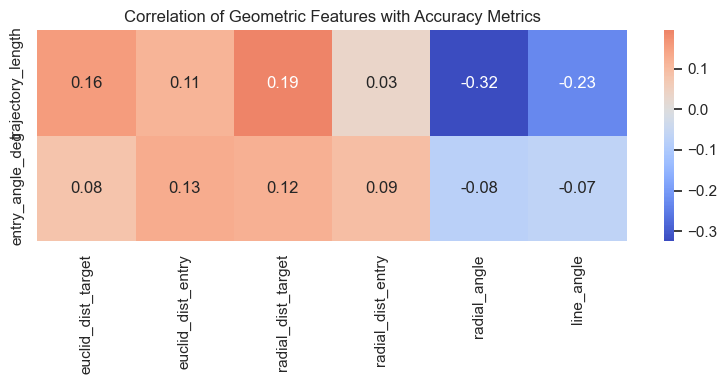

In [26]:
# Correlation between derived features and accuracy metrics
geo_corr = df_clean[['trajectory_length', 'entry_angle_deg'] + corr_vars].corr()

# Extract correlations only for trajectory features vs error metrics
geo_corr_subset = geo_corr.loc[['trajectory_length', 'entry_angle_deg'], corr_vars]

# Heatmap to visualize
plt.figure(figsize=(8, 4))
sns.heatmap(geo_corr_subset, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation of Geometric Features with Accuracy Metrics")
plt.tight_layout()
plt.show()


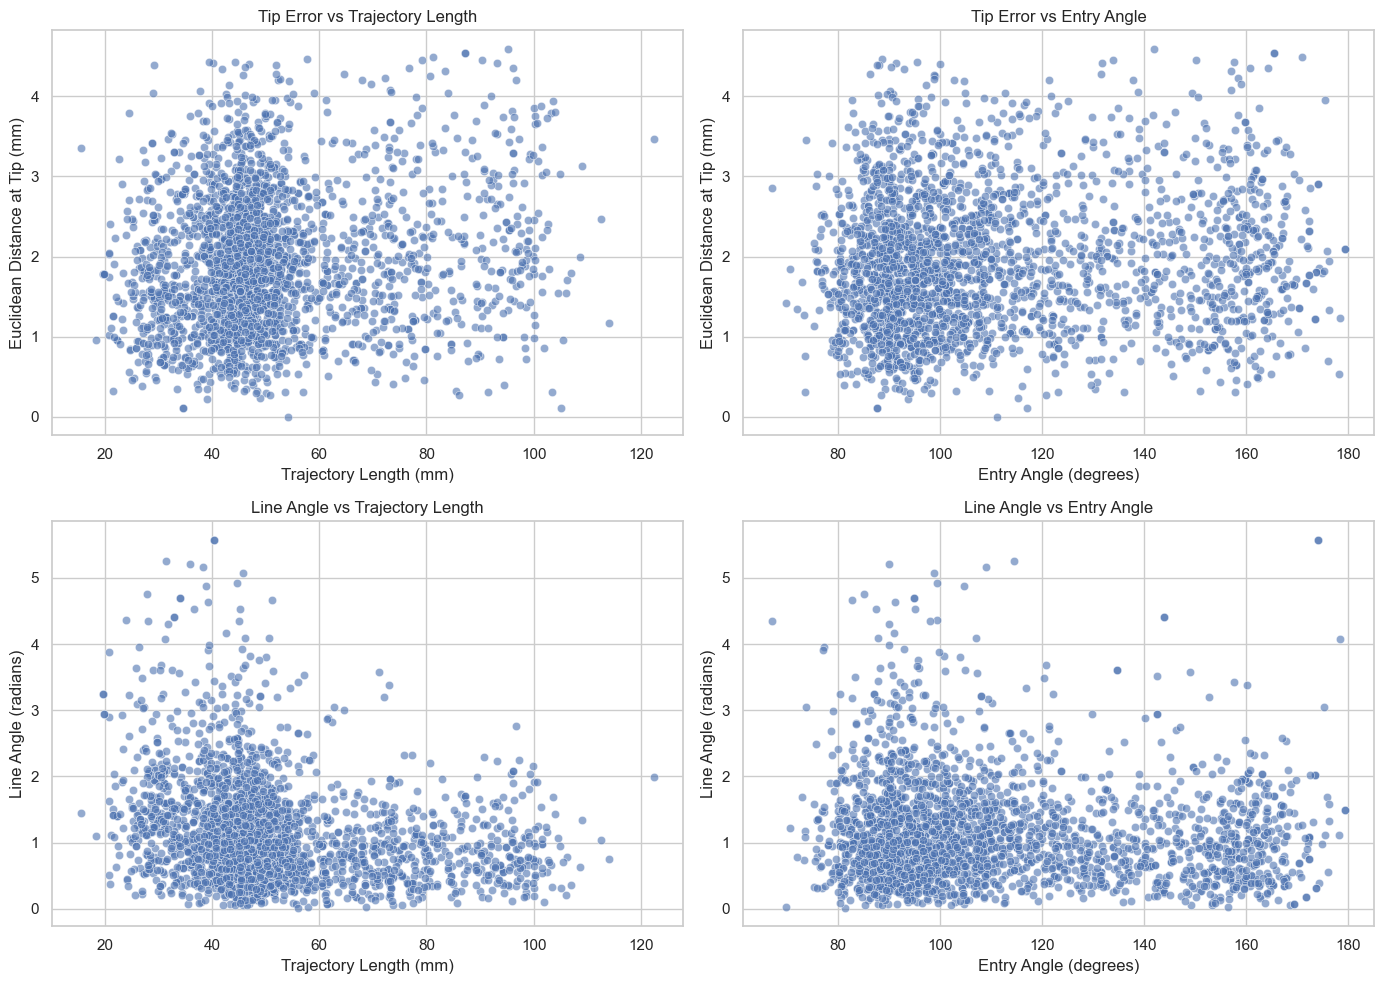

In [27]:
# Scatter plots to visualize how trajectory geometry affects error metrics

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Trajectory Length vs Tip Error
sns.scatterplot(data=df_clean, x='trajectory_length', y='euclid_dist_target', ax=axes[0, 0], alpha=0.6)
axes[0, 0].set_title("Tip Error vs Trajectory Length")
axes[0, 0].set_xlabel("Trajectory Length (mm)")
axes[0, 0].set_ylabel("Euclidean Distance at Tip (mm)")

# Entry Angle vs Tip Error
sns.scatterplot(data=df_clean, x='entry_angle_deg', y='euclid_dist_target', ax=axes[0, 1], alpha=0.6)
axes[0, 1].set_title("Tip Error vs Entry Angle")
axes[0, 1].set_xlabel("Entry Angle (degrees)")
axes[0, 1].set_ylabel("Euclidean Distance at Tip (mm)")

# Trajectory Length vs Line Angle
sns.scatterplot(data=df_clean, x='trajectory_length', y='line_angle', ax=axes[1, 0], alpha=0.6)
axes[1, 0].set_title("Line Angle vs Trajectory Length")
axes[1, 0].set_xlabel("Trajectory Length (mm)")
axes[1, 0].set_ylabel("Line Angle (radians)")

# Entry Angle vs Line Angle
sns.scatterplot(data=df_clean, x='entry_angle_deg', y='line_angle', ax=axes[1, 1], alpha=0.6)
axes[1, 1].set_title("Line Angle vs Entry Angle")
axes[1, 1].set_xlabel("Entry Angle (degrees)")
axes[1, 1].set_ylabel("Line Angle (radians)")

fig.tight_layout()
plt.show()


In [29]:
import statsmodels.api as sm

# Prepare data for regression
X = df_clean[['trajectory_length', 'entry_angle_deg']]
X = sm.add_constant(X)  # adds intercept
y = df_clean['euclid_dist_target']

# Fit linear regression model
model = sm.OLS(y, X).fit()

# Summarize results
model_summary = model.summary()
model_summary_text = model_summary.as_text()

# Extract coefficients and R-squared
coeffs = model.params
r_squared = model.rsquared

model_summary_text


'                            OLS Regression Results                            \n==============================================================================\nDep. Variable:     euclid_dist_target   R-squared:                       0.025\nModel:                            OLS   Adj. R-squared:                  0.024\nMethod:                 Least Squares   F-statistic:                     30.97\nDate:                Thu, 29 May 2025   Prob (F-statistic):           5.23e-14\nTime:                        21:48:19   Log-Likelihood:                -3075.0\nNo. Observations:                2459   AIC:                             6156.\nDf Residuals:                    2456   BIC:                             6174.\nDf Model:                           2                                         \nCovariance Type:            nonrobust                                         \n=====================================================================================\n                        coef    